In [201]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import datetime
import scipy
from matplotlib import pyplot as plt
import seaborn as sns
from googletrans import Translator
translator = Translator()

In [177]:
df = pd.read_csv('Base de datos SECOP.csv')
# asdlad

1

## Data Cleaning and Formatting

In [159]:
df['NIT ENTITY']= df['NIT ENTITY'].apply(lambda row: (str(row).replace(".","")) if row is not np.NaN else row)
df['NIT ENTITY']= df['NIT ENTITY'].apply(lambda row: (str(row).replace("-","")) if row is not np.NaN else row)
df['NIT ENTITY']= df['NIT ENTITY'].apply(lambda row: (str(row).replace(",","")) if row is not np.NaN else row)
df['NIT ENTITY']= df['NIT ENTITY'].apply(lambda row: (str(row)[0:3]+"."+str(row)[3:6]+"."+str(row)[6:9]+"-"+str(row)[9:10]) if row is not np.NaN else row)

df['AMOUNT']= df['AMOUNT'].apply(lambda row: (str(row).replace(",","")) if row is not np.NaN else row)
df['AMOUNT']= df['AMOUNT'].apply(lambda row: (str(row).replace(" -   ","")) if row is not np.NaN else row)


df["AMOUNT"]=df["AMOUNT"].str.replace(',','')
df["AMOUNT"]=df["AMOUNT"].str.replace(' -   ','')
df["AMOUNT"]=df["AMOUNT"].apply(pd.to_numeric)
# df["AMOUNT"]=df["AMOUNT"].replace(0,np.nan)
# df.iloc[539084,-3] = 0
# df[["AMOUNT","DEFINITIVE VALUE"]]

df["DIFFERENCE"]=(-df["AMOUNT"]+df["DEFINITIVE VALUE"])*100/df["AMOUNT"]
df["DIFFERENCE"]=df["DIFFERENCE"].replace(-np.inf,np.nan)
df["DIFFERENCE"]=df["DIFFERENCE"].replace(np.inf,np.nan)
df["VALUE ADDITIONS"]=df["VALUE ADDITIONS"].str.replace(',','')
df["VALUE ADDITIONS"]=df["VALUE ADDITIONS"].str.replace('.','')
df["VALUE ADDITIONS"]=df["VALUE ADDITIONS"].str.replace('$','')
df["VALUE ADDITIONS"]=df["VALUE ADDITIONS"].str.replace(' -   ','')
df["VALUE ADDITIONS"]= df["VALUE ADDITIONS"].apply(pd.to_numeric)
# df["VALUE ADDITIONS"]=df["VALUE ADDITIONS"].replace(0,np.nan)

df["LOG_AMOUNT"]=df["AMOUNT"].apply(lambda row: np.log(row) if df['AMOUNT'] is not 0 else row)
df["LOG_DEFINITIVE_VALUE"]=df["DEFINITIVE VALUE"].apply(lambda row: np.log(row) if df['DEFINITIVE VALUE'] is not 0 else row)
df["LOG_VALUE_ADDITIONS"]=df["VALUE ADDITIONS"].apply(lambda row: np.log(row) if df['VALUE ADDITIONS'] is not 0 else row)

### Grouping data according to entity name and sector

In [161]:
grouped_df = df.groupby(['ENTITY NAME ','SECTOR'])
sector_dict = {}
for a,b in grouped_df:
    (i,j) = a
    #creating a dictionary of entity name and sector
    sector_dict[i] = j

#creating dataframe from dictionary    
df_sec = pd.Series(sector_dict, name='SECTOR1')
df_sec.index.name = 'ENTITY NAME '
df_sec = df_sec.reset_index()

#joining the original dataframe to new dataframe
joined_df = pd.merge(df,df_sec,on='ENTITY NAME ', how='left')

#dropping original sector column and renaming new sector column
joined_df = joined_df.drop(columns=['SECTOR'])
joined_df = joined_df.rename(index=str, columns={"SECTOR1": "SECTOR"})

In [73]:
len(joined_df)

839080

## Implementation of Models

In [192]:
colsToTake = ['STATE PROCESS', 'ID OBJECT CONTRACT', 'LEVEL', 'ORDER', 'SECTOR', 'TYPE OF CONTRACT', 'TYPE MODALITY', 
              'AMOUNT','DIFFERENCE','YEAR','DETAIL OBJECT','CONTRACT OBJECT']
df2 = joined_df[colsToTake]
# colsText = []
# df4 = joined_df[colsText]

In [193]:
df2 = pd.concat([df2, pd.get_dummies(df2['STATE PROCESS'])], axis=1)
df2 = pd.concat([df2, pd.get_dummies(df2['ID OBJECT CONTRACT'])], axis=1)
df2 = pd.concat([df2, pd.get_dummies(df2['LEVEL'])], axis=1)
df2 = pd.concat([df2, pd.get_dummies(df2['ORDER'])], axis=1)
df2 = pd.concat([df2, pd.get_dummies(df2['SECTOR'])], axis=1)
df2 = pd.concat([df2, pd.get_dummies(df2['TYPE OF CONTRACT'])], axis=1)
df2 = pd.concat([df2, pd.get_dummies(df2['TYPE MODALITY'])], axis=1)
df2 = pd.concat([df2, pd.get_dummies(df2['YEAR'])], axis=1)
df2.drop(columns=['STATE PROCESS','ID OBJECT CONTRACT','LEVEL', 'ORDER','SECTOR','TYPE OF CONTRACT','TYPE MODALITY','YEAR'], inplace=True)
# print(df2.head())
# df2 = pd.concat([df2.iloc[:,1:], df2.iloc[:,0]], axis=1)
# print(df2.head())

### Scaling of Numeric Features

In [194]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

df2['DIFFERENCE'] = df2['DIFFERENCE'].apply(lambda row: np.absolute(row))
df2['DIFFERENCE'].min()
df3 = df2.dropna()

# print(df3['AMOUNT'].isnull().sum())

# Scale down Log of Amount between 0 and 1
amt = df3['AMOUNT'].apply(lambda row: np.log(row+1)).values.reshape(-1, 1)
scaler.fit(amt)
amt = scaler.transform(amt)
df3['LOG_AMOUNT'] = amt

# Scale down Amount between 0 and 1
amt = (df3['AMOUNT']).values.reshape(-1, 1)
scaler.fit(amt)
amt = scaler.transform(amt)
df3['AMOUNT'] = amt

# Scale down Log of Amount between 0 and 1
amt = df3['DIFFERENCE'].apply(lambda row: np.log(row+1)).values.reshape(-1, 1)
# print(amt.min())
# print(amt.max())
scaler.fit(amt)
amt = scaler.transform(amt)
df3['LOG_DIFFERENCE'] = amt

# Scale down the difference between 0 and 1
diff = (df3['DIFFERENCE']).values.reshape(-1, 1)
scaler.fit(diff)
diff = scaler.transform(diff)
df3['DIFFERENCE'] = diff

# print(df3.head())

C:\Users\Aniket\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\Aniket\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Aniket\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

# NLP

In [195]:
stopwords = ['de','la','que', 'el','en','y','a','los','del','se','las',
 'por',
 'un',
 'para',
 'con',
 'no',
 'una',
 'su',
 'al',
 'lo',
 'como',
 'más',
 'pero',
 'sus',
 'le',
 'ya',
 'o',
 'este',
 'sí',
 'porque',
 'esta',
 'entre',
 'cuando',
 'muy',
 'sin',
 'sobre',
 'también',
 'me',
 'hasta',
 'hay',
 'donde',
 'quien',
 'desde',
 'todo',
 'nos',
 'durante',
 'todos',
 'uno',
 'les',
 'ni',
 'contra',
 'otros',
 'ese',
 'eso',
 'ante',
 'ellos',
 'e',
 'esto',
 'mí',
 'antes',
 'algunos',
 'qué',
 'unos',
 'yo',
 'otro',
 'otras',
 'otra',
 'él',
 'tanto',
 'esa',
 'estos',
 'mucho',
 'quienes',
 'nada',
 'muchos',
 'cual',
 'poco',
 'ella',
 'estar',
 'estas',
 'algunas',
 'algo',
 'nosotros',
 'mi',
 'mis',
 'tú',
 'te',
 'ti',
 'tu',
 'tus',
 'ellas',
 'nosotras',
 'vosostros',
 'vosostras',
 'os',
 'mío',
 'mía',
 'míos',
 'mías',
 'tuyo',
 'tuya',
 'tuyos',
 'tuyas',
 'suyo',
 'suya',
 'suyos',
 'suyas',
 'nuestro',
 'nuestra',
 'nuestros',
 'nuestras',
 'vuestro',
 'vuestra',
 'vuestros',
 'vuestras',
 'esos',
 'esas',
 'estoy',
 'estás',
 'está',
 'estamos',
 'estáis',
 'están',
 'esté',
 'estés',
 'estemos',
 'estéis',
 'estén',
 'estaré',
 'estarás',
 'estará',
 'estaremos',
 'estaréis',
 'estarán',
 'estaría',
 'estarías',
 'estaríamos',
 'estaríais',
 'estarían',
 'estaba',
 'estabas',
 'estábamos',
 'estabais',
 'estaban',
 'estuve',
 'estuviste',
 'estuvo',
 'estuvimos',
 'estuvisteis',
 'estuvieron',
 'estuviera',
 'estuvieras',
 'estuviéramos',
 'estuvierais',
 'estuvieran',
 'estuviese',
 'estuvieses',
 'estuviésemos',
 'estuvieseis',
 'estuviesen',
 'estando',
 'estado',
 'estada',
 'estados',
 'estadas',
 'estad',
 'he',
 'has',
 'ha',
 'hemos',
 'habéis',
 'han',
 'haya',
 'hayas',
 'hayamos',
 'hayáis',
 'hayan',
 'habré',
 'habrás',
 'habrá',
 'habremos',
 'habréis',
 'habrán',
 'habría',
 'habrías',
 'habríamos',
 'habríais',
 'habrían',
 'había',
 'habías',
 'habíamos',
 'habíais',
 'habían',
 'hube',
 'hubiste',
 'hubo',
 'hubimos',
 'hubisteis',
 'hubieron',
 'hubiera',
 'hubieras',
 'hubiéramos',
 'hubierais',
 'hubieran',
 'hubiese',
 'hubieses',
 'hubiésemos',
 'hubieseis',
 'hubiesen',
 'habiendo',
 'habido',
 'habida',
 'habidos',
 'habidas',
 'soy',
 'eres',
 'es',
 'somos',
 'sois',
 'son',
 'sea',
 'seas',
 'seamos',
 'seáis',
 'sean',
 'seré',
 'serás',
 'será',
 'seremos',
 'seréis',
 'serán',
 'sería',
 'serías',
 'seríamos',
 'seríais',
 'serían',
 'era',
 'eras',
 'éramos',
 'erais',
 'eran',
 'fui',
 'fuiste',
 'fue',
 'fuimos',
 'fuisteis',
 'fueron',
 'fuera',
 'fueras',
 'fuéramos',
 'fuerais',
 'fueran',
 'fuese',
 'fueses',
 'fuésemos',
 'fueseis',
 'fuesen',
 'sintiendo',
 'sentido',
 'sentida',
 'sentidos',
 'sentidas',
 'siente',
 'sentid',
 'tengo',
 'tienes',
 'tiene',
 'tenemos',
 'tenéis',
 'tienen',
 'tenga',
 'tengas',
 'tengamos',
 'tengáis',
 'tengan',
 'tendré',
 'tendrás',
 'tendrá',
 'tendremos',
 'tendréis',
 'tendrán',
 'tendría',
 'tendrías',
 'tendríamos',
 'tendríais',
 'tendrían',
 'tenía',
 'tenías',
 'teníamos',
 'teníais',
 'tenían',
 'tuve',
 'tuviste',
 'tuvo',
 'tuvimos',
 'tuvisteis',
 'tuvieron',
 'tuviera',
 'tuvieras',
 'tuviéramos',
 'tuvierais',
 'tuvieran',
 'tuviese',
 'tuvieses',
 'tuviésemos',
 'tuvieseis',
 'tuviesen',
 'teniendo',
 'tenido',
 'tenida',
 'tenidos',
 'tenidas',
 'tened']

In [196]:
from sklearn.feature_extraction.text import CountVectorizer
import scipy

corpus = df3.loc[:,'DETAIL OBJECT']
# corpus = corpus.apply(lambda r: )
corpus = corpus.fillna('')
corpus = list(corpus)

corpus2 = df3.loc[:,'CONTRACT OBJECT']
corpus2 = corpus2.fillna('')
corpus2 = list(corpus2)


def corpusToBagOfWords(corpus):
    vectorizer = CountVectorizer(max_df=0.5,min_df=0.00001,max_features=100000,stop_words=stopwords)
    X = vectorizer.fit_transform(corpus)
    columns = vectorizer.get_feature_names()
    return (X,columns)

bag = corpusToBagOfWords(corpus)
bag_contract = corpusToBagOfWords(corpus2)

X1 = bag[0]

X2 = bag_contract[0]
# print(X2)

In [197]:
# df3 = df3.astype(float)
# X = scipy.sparse.csr_matrix(df3.values)

df3.drop(labels=['DETAIL OBJECT', 'CONTRACT OBJECT'], axis=1, inplace=True)
df3 = df3.astype(float)
X = scipy.sparse.csr_matrix(df3.values)

from scipy.sparse import hstack
X4 = hstack((X,X1,X2))
# YS = scipy.sparse.csr_matrix(Y.values)

C:\Users\Aniket\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


# Model Implementation

Implementation of Linear Regression to predict amount for each contract and find out contracts with highest residuals. We could call them as anomalies.

In [100]:
# df - input data frame containing the data
# output - output variable
# k - number of cross-validation folds
# model - functions that builds regression model
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression as lm
import math

# Linear model
# Assumes the last column of data is the output dimension
def get_pred_lr(train,test):
    n,m = train.shape #number of rows and columns
    X = train.iloc[:,:m-1] #get training input data
    y = train.iloc[:, -1] #get training output data
    query = test.iloc[:,:m-1] #get test input data
    reg = lm(copy_X=True).fit(X, y)
    #print 'R-squared: ' + str(reg.score(X,y))
    pred = reg.predict(query)
    #print 'Pred shape' + str(pred.shape)
    # You may leverage the linear_model module from sklearn (scikit-learn)
    return pred

def do_cv(df, output, k, model):
    kfold = KFold(n_splits=k, shuffle=True)
    kfold.get_n_splits(df)

    mse = pd.Series()
    for train, test in kfold.split(df):
        y_hat = pd.Series()
        y = pd.Series()

        y_hat = y_hat.append(pd.Series(model(df.iloc[train], df.iloc[test])), ignore_index=True)
        #print 'breakpoint 1'
        y = y.append(pd.Series(df.iloc[:,-1][test]), ignore_index=True)
        #print 'breakpoint 2'
        #print 'yhat: ' + str(y_hat.shape) + ' y: ' + str(y.shape)
        #mse = mean_squared_error(y, y_hat)
        
        #print mse.shape
        mse = mse.append(pd.Series([math.sqrt(mean_squared_error(y, y_hat))]), ignore_index=True)
        #print 'breakpoint 3'
    return mse

In [203]:
## Isolation Forest
from sklearn.ensemble import IsolationForest

clf = IsolationForest(contamination= 0.00001, n_jobs=-1, bootstrap=True)
print("Fitting")
clf = clf.fit(X4)
print("Predicting")
predict = clf.predict(X4)

print("%d out of %d abnormalities detected" % (sum(predict==-1),predict.size))

Fitting
Predicting
10 out of 833053 abnormalities detected


In [239]:
# print(df3.head())
anomaly = np.where(predict==-1)
# print(anomaly[0])
df9 = df2.dropna()
anomaly_df = df9.iloc[anomaly[0],:]
print(anomaly_df)
anomaly_df.to_csv('Anomaly_DF.csv')
# print(predict[predict==-1])

              AMOUNT  DIFFERENCE  \
184495  3.780000e+07         0.0   
302593  2.363850e+07         0.0   
561490  2.597931e+09         0.0   
679237  1.210000e+07         0.0   
684435  5.130000e+06         0.0   
689556  2.000000e+07         0.0   
689665  5.094000e+06         0.0   
693061  5.094000e+06         0.0   
701469  8.914500e+06         0.0   
765819  9.350000e+06         0.0   

                                            DETAIL OBJECT  \
184495  EL CONTRATISTA SE COMPROMETE A PRESTAR SUS SER...   
302593  PRESTAR SUS SERVICIOS PROFESIONALES COMO INGEN...   
561490  DESARROLLAR LA INTERVENTORIA ADMINISTRATIVA ,T...   
679237  Prestación de Servicios Profesionales, previas...   
684435  Prestar a la Unidad para la Atención y Reparac...   
689556  EL CONTRATISTA SE COMPROMETE PARA CON CORTOLIM...   
689665  Prestar a la Unidad para la Atención y Reparac...   
693061  Prestar a la Unidad para la Atención y Reparac...   
701469  Prestar a la Unidad Administrativa Especial pa

### Interpreting the results
Isolation forest has no interpreation of the process of identifying anomalies. Therefore, we used random forest to identify features that could have contributed in anomaly detection.

In [286]:
## Random Forest Feature Importance
# print(np.unique(predict))
pred = [0 if x == 1 else 1 for x in predict]
pred = np.transpose(pred)
Y = scipy.sparse.csr_matrix(pred)


In [291]:
print(pred.shape)
print((Y.transpose()).shape)
print((X4).shape)

(833053,)
(833053, 1)
(833053, 34470)


In [292]:
#Trying to fit a logistic regression to find coefficients for each feature, because all inputs are in a range of 0 and 1 and coefficients will indicate which variables are important
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit((X4),pred)
coeff = logreg.coef_
intercept = logreg.intercept_

print(coeff)

[[-8.69976807e-05 -1.80719319e-05 -2.18463212e-04 ... -6.87222942e-02
  -5.91250330e-03 -1.27044601e-02]]


In [1]:
cols = df3.columns.tolist()
# cols = cols.append(['DETAIL OBJECT', 'CONTRACT OBJECT'])
print(len(cols))

df_final = pd.DataFrame(coeff[:,:144], columns=cols)
print((df_final.transpose()).sort_values(by='0',axis=0))
# print(intercept)

#### K-means Clustering to identify outliers by varying the value of K and choosing the cluster with minimal data points

In [139]:
from sklearn.cluster import KMeans

# Fitting the model
kmeans = KMeans(n_clusters=2, random_state=0).fit(df3)
avail_label = kmeans.labels_

In [3]:
## PCA for Feature Reduction
# Y = X4.toarray()

from sklearn.decomposition import PCA

pca = PCA()
X_pca = pca.fit_transform(Y)

## Scree Plot

exp_var = pca.explained_variance_ratio_[:10]
#eigen_val = pca.singular_values_[:5]

plt.plot(exp_var, color='k', marker='.')
plt.grid(linestyle='-', color='grey', linewidth=0.2)
plt.title('Scree Plot')
plt.xlabel('Principal Component Index')
plt.ylabel('Eigen Value')
plt.xticks(np.arange(10),np.arange(1,11))
plt.savefig('Scree Plot.png')
plt.show()

In [142]:
print(avail_label.sum())

524982


In [114]:
print(len(df2))
df3 = df2.dropna()
print(len(df3))

839080
833983


In [106]:
df2.to_csv('Base de datos SECOP_Encoded.csv')

## Translation for Values of column - "CONTRACT OBJECT" (Not included) - Future Work


In [44]:
### Code to translate "Contract Object"
# obj_contract = df['CONTRACT OBJECT'].value_counts()
# obj_contract = obj_contract.reset_index()
# for x in np.arange(len(obj_contract)):
# #     print(obj_contract.iloc[x,0])
#     print(translator.translate(obj_contract.iloc[x,0]).text)
#     print("\n")
# print(obj_contract.iloc[0,0])
# print([translator.translate(obj_contract[x]).text for x in np.arange(len(obj_contract))])
# obj_contract = [translator.translate(x).text for x in obj_contract]

Management Services, Professional Business Services and Administrative Services
Construction, Repair and Maintenance Services
Personal and Domestic Services
Educational and Training Services
Building Services, Construction of Facilities and Maintenance
Health services
Food, Beverages and Tobacco
Transportation, Storage and Mail Services
Equipment, Accessories and Office Supplies
Components and Supplies for Structures, Building, Construction and Civil Works
Travel, Food, Accommodation and Entertainment Services
Environmental Services
Components and Industrial Supplies and Hardware
Clothing, Luggage and Personal Care Products
Fuels, Fuel Additives, Lubricants and Anticorrosive Materials
Public Services, Information and Telecommunications Services
Editorial, Design, Graphic Arts, Multicopy and Fine Arts Services
Cleaning, Decontamination and Waste Treatment Services
Commercial, Military and Private Vehicles, Accessories and Components
Furniture and Furniture
Organizations and Clubs
Softwa

In [19]:
df.columns.tolist()
df['CONTRACT OBJECT'].value_counts()

Servicios de Gestion, Servicios Profesionales de Empresa y Servicios Administrativos                  314329
Servicios de Construcción, Reparación y Mantenimiento                                                  63588
Servicios Personales y Domésticos                                                                      55256
Servicios Educativos y de Formación                                                                    39790
Servicios de Edificación, Construcción de Instalaciones y Mantenimiento                                31257
Servicios de Salud                                                                                     28441
Alimentos, Bebidas y Tabaco                                                                            22037
Servicios de Transporte, Almacenaje y Correo                                                           17563
Equipo, Accesorios y Suministros de Oficina                                                            17193
Componentes y Sumin

In [ ]:
### Translation of column names
# cols = df.columns.tolist()
# for x in np.arange(len(cols)):
#     if cols[x]=="FECHAESTADOBORRADOR" in cols: cols[x] = "STATE DRAFT DATE"
#     if cols[x]=="FECHAESTADODESCARTADO" in cols: cols[x] = "DATE STATUS DESCRIBED"
#     if cols[x]=="FECHAESTADOCONVOCADO" in cols: cols[x] = "STATE DATE CALLED"
#     if cols[x]=="FECHAESTADOADJUDICADO" in cols: cols[x] = "DATE STATUS AWARDED"
#     if cols[x]=="FECHAESTADOTERMANORMALDESPCONV" in cols: cols[x] = "STATE DATE ABNORMAL TERM OF SPCONV"
#     if cols[x]=="FECHAESTADOTERMANORMALDESPCONV_1" in cols: cols[x] = "STATE DATE ABNORMAL TERM OF SPCONV 1"
#     if cols[x]=="FECHAESTADOTERMANORMALDESPCONV_2" in cols: cols[x] = "STATE DATE ABNORMAL TERM OF SPCONV 2"
#     if cols[x]=="FECHAESTADOTERMANORMALDESPCONV_3" in cols: cols[x] = "STATE DATE ABNORMAL TERM OF SPCONV 3"
#     cols[x] = cols[x].replace("_", " ")
#     print(cols[x])
#     cols[x] = translator.translate(cols[x]).text
#     print(cols[x] + "\n")
# # print(translator.translate(cols[2]).text)
# df.columns = cols
# # print(cols)

In [101]:
print('Linear Regression')
mse = do_cv(df2.dropna(), 'AMOUNT', 2, get_pred_lr)

Linear Regression


### Feature Engineering (II) - Unused
Creating feature called Creation Year and month to find patterns in data. This was highlighted after finding out that creation date was sometimes later than the date of signing the contract

In [2]:
df = pd.read_csv("duplicate_processed.csv")

/Users/paridhichoudhary/miniconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (9,13,26) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [9]:
df['CREATION YEAR'] = df['CREATION DATE'].apply(lambda r: '20'+r.split('/')[2] if len(r.split('/')[2])==2 else r.split('/')[2])
df['CREATION MONTH'] = df.apply(lambda r: r['CREATION DATE'].split('/')[0] if r['YEAR']<2011 else r['CREATION DATE'].split('/')[0], axis = 1)

In [10]:
pd.unique(df['CREATION MONTH'])

array(['18', '16', '29', '17', '05', '15', '14', '22', '11', '24', '04',
       '10', '19', '23', '03', '09', '30', '21', '02', '28', '25', '07',
       '08', '12', '26', '13', '27', '20', '06', '01', '9', '5', '6', '3',
       '4', '2', '8', '1', '7'], dtype=object)

In [ ]:
df[~df['DATE SIGN CONTRACT'].isnull()]['DATE SIGN YEAR'] = df[~df['DATE SIGN CONTRACT'].isnull()]['DATE SIGN CONTRACT'].apply(lambda r: '20'+r.split('/')[2] if len(r.split('/')[2])==2 else r.split('/')[2])
df[~df['r['CREATION DATE'].split('/')[0]'].isnull()]['DATE SIGN MONTH'] = df[~df['DATE SIGN CONTRACT'].isnull()].apply(lambda r: r['DATE SIGN CONTRACT'].split('/')[0])
df[df['DATE SIGN CONTRACT'].isnull()]['DATE SIGN YEAR'] =0
df[df['DATE SIGN CONTRACT'].isnull()]['DATE SIGN MONTH'] =0
df['CONTRACT LENGTH'] = (df['DATE SIGN MONTH'] - df['CREATION MONTH'])+12*(df['DATE SIGN YEAR'] - df['CREATION YEAR'])
df['CONTRACT LATER STARTED'] = df.apply(lambda r:1 if r['CREATION YEAR']>r['YEAR'] else 0,axis=1)

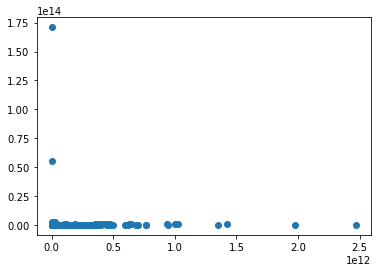

In [19]:
# df['AMOUNT'] = df['AMOUNT'].apply(lambda r: int(r.replace(',',"").replace("-","0")))
# df['Quantity'] = df['Quantity'].apply(lambda r: int(r.replace(',',"").replace("-","0")))


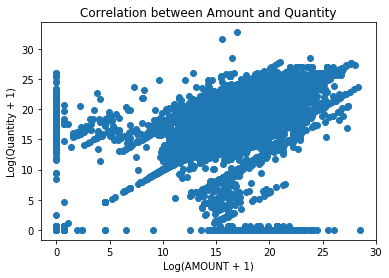

In [24]:
plt.scatter(np.log(df['AMOUNT']+1),np.log(df['Quantity']+1))
plt.xlabel('Log(AMOUNT + 1)')
plt.ylabel('Log(Quantity + 1)')
plt.title("Correlation between Amount and Quantity")
plt.show()

In [25]:
df.columns

Index(['Unnamed: 0', 'Quantity', 'DETAIL OBJECT', 'STATE PROCESS',
       'CREATION DATE', 'DATE STATUS AWARDED', 'STATE DRAFT DATE',
       'STATE DATE CALLED', 'DATE STATUS DESCRIBED',
       'STATE DATE ABNORMAL TERM OF SPCONV',
       'STATE DATE ABNORMAL TERM OF SPCONV 1',
       'STATE DATE ABNORMAL TERM OF SPCONV 2',
       'STATE DATE ABNORMAL TERM OF SPCONV 3', 'DATE SIGN CONTRACT',
       'ID OBJECT CONTRACT', 'NIT Contractor', 'NIT ENTITY', 'LEVEL',
       'CONTRACTOR NAME', 'ENTITY NAME ', 'CONSTANCE NUMBER',
       'CONTRACT OBJECT', 'ORDER', 'TYPE OF CONTRACT', 'TYPE MODALITY',
       'VALUE ADDITIONS', 'CONTRACT VALUE', 'AMOUNT', 'DEFINITIVE VALUE',
       'YEAR', 'SECTOR', 'duplicate_isTrue', 'CREATION YEAR',
       'CREATION MONTH'],
      dtype='object')

In [48]:
# df[(df['AMOUNT']==2597931446) &(df['STATE PROCESS']=="Liquidado")]
len(df[(df['AMOUNT']==12100000) & (df['YEAR']==2012)]['DETAIL OBJECT'])

394

In [61]:
(df[(df['AMOUNT']==20000000) & (df['YEAR']==2012)])


,Unnamed: 0,Quantity,DETAIL OBJECT,STATE PROCESS,CREATION DATE,DATE STATUS AWARDED,STATE DRAFT DATE,STATE DATE CALLED,DATE STATUS DESCRIBED,STATE DATE ABNORMAL TERM OF SPCONV,...,TYPE MODALITY,VALUE ADDITIONS,CONTRACT VALUE,AMOUNT,DEFINITIVE VALUE,YEAR,SECTOR,duplicate_isTrue,CREATION YEAR,CREATION MONTH
458185,473362,53000000.0,suministro de viveres y rancho para el estable...,Celebrado,13/01/12,NaN,13/01/12,NaN,NaN,NaN,...,Contratación Mínima Cuantía,-,20000000,20000000,20000000.0,2012,JUSTICIA Y DEL DERECHO,0,2012,13
458231,473408,20000000.0,"SUMINISTRO DE COMBUSTIBLE (ACPM), CON EL PRO...",Celebrado,13/01/12,NaN,13/01/12,NaN,NaN,NaN,...,Contratación Mínima Cuantía,-,20000000,20000000,20000000.0,2012,DEFENSA NACIONAL,0,2012,13
458315,473496,20000000.0,Prestación de servicios profesionales para apo...,Liquidado,11/01/12,NaN,11/01/12,NaN,NaN,NaN,...,Contratación Directa (Ley 1150 de 2007),-,20000000,20000000,20000000.0,2012,RELACIONES EXTERIORES,0,2012,11
458321,473502,20000000.0,La Empresa Social del Estado Centro de Salud d...,Celebrado,10/01/12,01/02/12,10/01/12,17/01/12,NaN,NaN,...,Selección Abreviada de Menor Cuantía (Ley 1150...,-,20000000,20000000,20000000.0,2012,NaN,0,2012,10
458362,473543,20000000.0,SUMINISTRO DE ALMUERZOS PARA LOS AGENTES DE PO...,Celebrado,10/01/12,NaN,10/01/12,NaN,NaN,NaN,...,Contratación Mínima Cuantía,-,20000000,20000000,20000000.0,2012,NaN,0,2012,10
459395,474618,16000000.0,PRESTAR SERVICIOS PROFESIONALES COMO ABOGADO E...,Liquidado,26/01/12,NaN,26/01/12,NaN,NaN,NaN,...,Contratación Directa (Ley 1150 de 2007),"40,00,000",16000000.0,20000000,20000000.0,2012,NaN,0,2012,26
459609,474833,20000000.0,PRESTAR SERVICIOS PROFESIONALES COMO ABOGADO E...,Liquidado,30/01/12,NaN,30/01/12,NaN,NaN,NaN,...,Contratación Directa (Ley 1150 de 2007),-,20000000.0,20000000,20000000.0,2012,NaN,0,2012,30
459827,475052,20000000.0,"PRESTAR EL SERVICIO DE MANTENIMIENTO, REPARACI...",Celebrado,30/01/12,NaN,30/01/12,NaN,NaN,NaN,...,Contratación Mínima Cuantía,-,20000000.0,20000000,20000000.0,2012,NaN,0,2012,30
459921,475146,16000000.0,PRESTAR SERVICIOS PROFESIONALES COMO ABOGADO E...,Liquidado,26/01/12,NaN,26/01/12,NaN,NaN,NaN,...,Contratación Directa (Ley 1150 de 2007),"40,00,000",16000000.0,20000000,20000000.0,2012,NaN,0,2012,26
459945,475170,20000000.0,"CONSULTA MEDICA ESPECIALIZADA, PROCEDIMIENTOS...",Celebrado,16/01/12,NaN,16/01/12,NaN,NaN,NaN,...,Contratación Mínima Cuantía,-,20000000.0,20000000,20000000.0,2012,FUERZAS ARMADAS,0,2012,16


In [65]:
# Function to provide summary of data
# Provides summary of Numerical and Categorical Attributes of a dataset
def brief(df):
    returnString = ""
    numRows = len(df)
    numColumns = len(df.columns)
    # Append parts of the string to the returnString
    returnString += "This dataset has " + str(numRows) + " Rows " + str(numColumns) + " Attributes" + '\n'+'\n'
    # Describe function to fetch some summary statistics
    numeric_df = df.describe()
    #Keep only relevant statistics and take transpose
    numeric_df_T = numeric_df.transpose().loc[:, ['mean', '50%', 'std', 'min', 'max']]
    # Rearrangement of columns
    numeric_df_T.columns = ['Mean','Median','Sdev','Min','Max']
    numeric_df_T['Missing'] = 0
    numeric_df_T['Attribute_ID'] = 0
    for i in numeric_df_T.index:
        # Counting number of Missing values
        numeric_df_T.loc[i, 'Missing'] = df[i].isnull().sum()
        # Introducing column to keep track of original Attribute position
        numeric_df_T.loc[i, 'Attribute_ID'] = list(df.columns).index(i) + 1
    numeric_df_T['Attribute_Name'] = numeric_df_T.index
    # Starting index from 1
    numeric_df_T.index = range(1, len(numeric_df_T) + 1)
    # Final re-arrangement of Numeric Attributes
    numeric_df_T = numeric_df_T.loc[:,['Attribute_ID', 'Attribute_Name', 'Missing', 'Mean', 'Median', 'Sdev', 'Min', 'Max']]
    returnString+="real valued attributes"+'\n' + "-"*len("real valued attributes")+'\n'
    returnString += numeric_df_T.to_string()+'\n'
    returnString += "symbolic attributes" + '\n' + "-" * len("symbolic attributes") + '\n'
    cols = df.columns
    num_cols = df._get_numeric_data().columns
    # Finding the categorical columns
    cat_cols = list(set(cols) - set(num_cols))
    # Making the initial dataframe with all categorical attributes names and IDs
    sym_df = pd.DataFrame({'Attribute_ID':[list(df.columns).index(i)+1 for i in cat_cols],'Attribute_Name':cat_cols})
    #Initializing values
    sym_df['Missing']=0
    sym_df['arity'] = 0
    sym_df['MCVs_counts'] = ""
    #Iterate over all categorical variables and find number of missing and arity and MCV counts
    for i in range(len(cat_cols)):
        #Add Missing value as the second column
        sym_df.iloc[i,2]=df.loc[:,cat_cols[i]].isnull().sum()
        # Drop NA values before arity and MCV counts
        series_without_missing = df.loc[:,cat_cols[i]].dropna()
        # Count frequency of each category
        series_wo_miss_counts = series_without_missing.value_counts()
        # Sort the values
        series_wo_miss_counts.sort_values(inplace=True, ascending=False)
        # Arity count the number of unique values
        sym_df.iloc[i, 3] = len(series_wo_miss_counts)
        # MCV string to iterate over all these values and include their count
        mcv_string = ""
#         for j in range(min(3,len(series_wo_miss_counts))):
#             mcv_string+=str(series_wo_miss_counts.index[j])+"("+str(series_wo_miss_counts[j])+") "
#         # Add this string as the 4th column in the dataframe
        sym_df.iloc[i, 4] = mcv_string
    sym_df.index = range(1, len(sym_df) + 1)
    #Add the dataframe to the string
    returnString += sym_df.to_string() + '\n'
    return returnString


In [67]:
df.drop(labels="Unnamed: 0",axis=1)
print(brief(df))

This dataset has 814348 Rows 34 Attributes

real valued attributes
----------------------
   Attribute_ID         Attribute_Name  Missing          Mean      Median          Sdev         Min           Max
1             1             Unnamed: 0        0  4.197421e+05    419878.5  2.422047e+05         0.0  8.390790e+05
2             2               Quantity        0  5.260808e+08  12800000.0  1.991691e+11         0.0  1.710000e+14
3             9  DATE STATUS DESCRIBED   814348           NaN         NaN           NaN         NaN           NaN
4            15     ID OBJECT CONTRACT        0  7.146404e+07  80000000.0  1.938707e+07  10000000.0  9.400000e+07
5            28                 AMOUNT        0  1.831594e+08  12120000.0  6.084385e+09         0.0  2.472049e+12
6            29       DEFINITIVE VALUE      880  2.776421e+08  12636000.0  3.633645e+10         0.0  3.224800e+13
7            30                   YEAR        0  2.010655e+03      2011.0  1.559171e+00      2007.0  2.012000e+0